In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from timeit import default_timer as timer



from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [4]:

select_station = 'ATTO'

In [5]:
xr.set_options(keep_attrs=True) 

In [6]:
calc_seasons = ['ALL_year']

In [7]:
tau_lims = [5,50]
r_eff_lim = 1
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

In [8]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'



In [9]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-2


temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

### Define some strings for files

In [17]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

## Daytime values


Set the daytime to be from 10 to 17 each day

In [10]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [11]:
models = ['ECHAM-SALSA','NorESM','EC-Earth']
mod2cases = {'ECHAM-SALSA':['SALSA_BSOA_feedback'],
             'NorESM':['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth':['ECE3_output_Sara'],
            }
di_mod2cases = mod2cases.copy()

In [12]:
dic_df_station=dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara.csv


<AxesSubplot:xlabel='time'>

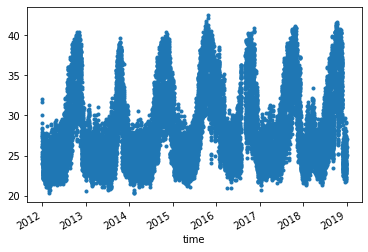

In [13]:
dic_df_station[mod][ca]['T_C'].plot(marker='.')

## EC-Earth

### Defintions

#### Names etc

In [14]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Input path:

In [15]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [16]:

cases_ec_earth = [case_name_ec_earth]

#### Filenames: 

In [18]:
fn_intermediate_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [19]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0')

### Open pre calculated extracted fields

In [20]:
which='IFS'

In [21]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'


In [23]:
fl_open = []
#ds_list =[]
dic_ds =dict()

for which in ['IFS','IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')
        

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [24]:
import numpy as np

In [26]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
    make_dummy_lev,
    
)

#### Fix units, calc cloud properties etc.

In [29]:
if not fn_intermediate_ec_earth.exists():
    

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds=rename_ifs_vars(_ds)
        
        _ds = fix_units_ec_earth(_ds)
        #_ds = calculate_incld_values_warmclouds(_ds)
        #_ds = extract_cloud_top(_ds)
        #_ds['lat'] = np.round(_ds['lat'], decimals=2)
        #_ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds=(
            _ds
            .assign(
                lat=lambda d:d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d:d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds
    

    ds = dic_ds['IFS']
    

    ds = calculate_incld_values_warmclouds(ds)
    

    ds = extract_cloud_top(ds)
    
    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev= model_lev_i)
        dic_ds[key] = ds_l

  

      
    ds_t = dic_ds['IFS_T']
    
    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U','V','temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']),ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()
    

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()
    

### Open file with fixed units and extracted cloud params:

In [124]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)


#### Fix units and decode time

In [125]:
ds_ifs['ttc'].attrs['units'] =1

for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units']==1:
            ds_ifs[v].attrs['units'] ='1'
            print(f'{v} unit is 1')

ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cl_time_liq_norm sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cwp_incld g m-2
cloud_time_norm sec
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_cltop  um
cc_cltop 1
temp K


### Overview plots

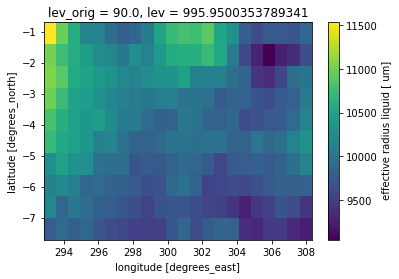

In [126]:
ds_ifs['re_liq_cltop'].count('time').plot()

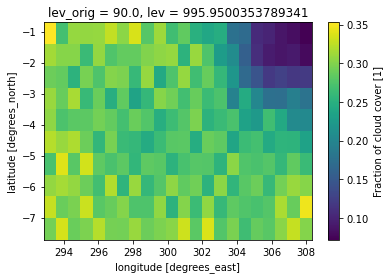

In [127]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

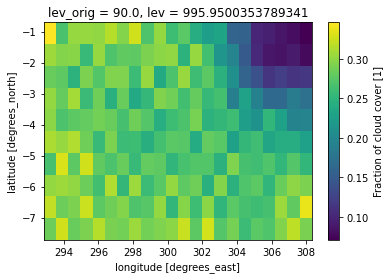

In [128]:
ds_ifs['cc_all'].mean('time').plot()

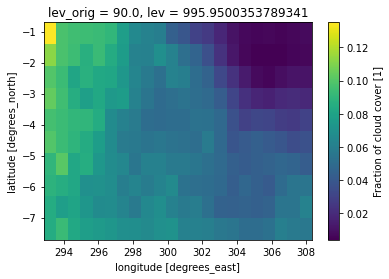

In [129]:
ds_ifs['cc'].mean('time').plot()

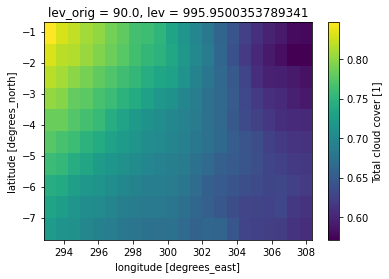

In [130]:
ds_ifs['ttc'].mean('time').plot()

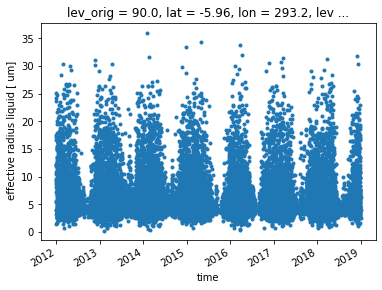

In [131]:
ds_ifs['re_liq'].isel(lat=2,lon=0).plot(x='time', linewidth=0, marker='.')

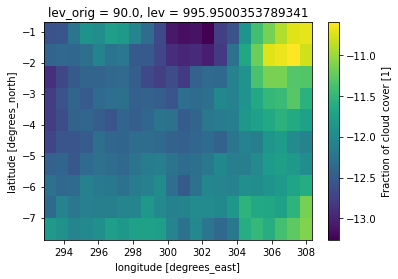

In [132]:
ds_ifs['argmax'].mean('time').plot()

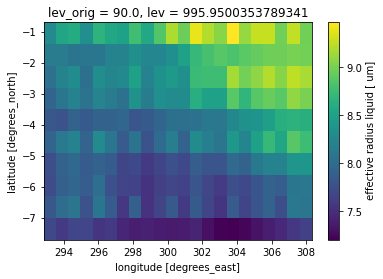

In [133]:
ds_ifs['re_liq_cltop'].mean('time').plot()

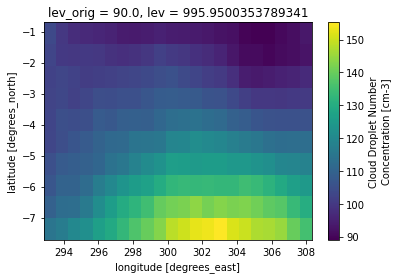

In [134]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

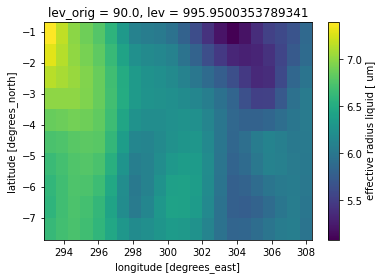

In [135]:
ds_ifs['re_liq'].mean('time').plot()

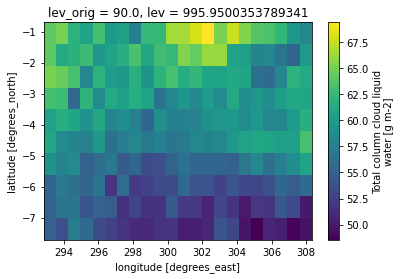

In [136]:
ds_ifs['tclw'].mean('time').plot()

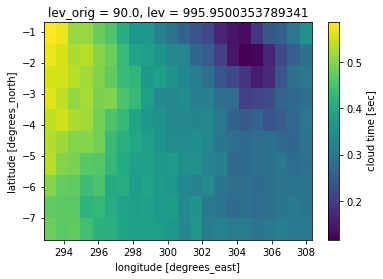

In [137]:
ds_ifs['cloud_time_norm'].mean('time').plot()

In [138]:
import numpy as np

In [139]:
import numpy as np

### Masking and computing vars

#### Mask values where cloud fraction is less than 10 percent

In [140]:
xr.set_options(keep_attrs=True)

In [141]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop']>.1)


#### Take only values where liquid cloud fraction is above 80%

In [ ]:
ds_ifs = ds_ifs.where( ds_ifs['liq_frac_cwp']>.8)

(array([ 49956.,  53162.,  57375.,  61839.,  69190.,  78526.,  93685.,
        116522., 142299., 312402.]),
 array([0.8000161 , 0.8200145 , 0.8400129 , 0.8600113 , 0.88000965,
        0.9000081 , 0.92000645, 0.9400048 , 0.9600032 , 0.9800016 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

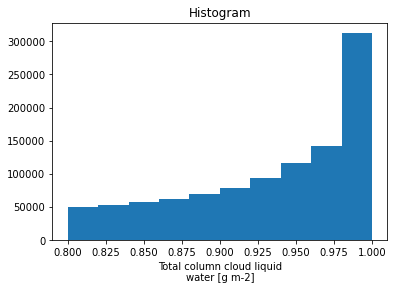

In [ ]:
ds_ifs['liq_frac_cwp'].plot()

### Shift timezone

In [149]:
from datetime import timedelta
with ProgressBar():
    ds_ifs.load()
    
    
if ds_ifs['time'].attrs['timezone']=='utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

### Use station data computed before:

In [150]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [151]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=[select_station])

(array([1.86000e+02, 2.89750e+04, 2.02167e+05, 2.19822e+05, 2.09196e+05,
        1.19435e+05, 9.29140e+04, 1.05617e+05, 5.39190e+04, 2.72500e+03]),
 array([290.4117 , 292.9765 , 295.5413 , 298.1061 , 300.6709 , 303.2357 ,
        305.80048, 308.36526, 310.93008, 313.49487, 316.05966],
       dtype=float32),
 <BarContainer object of 10 artists>)

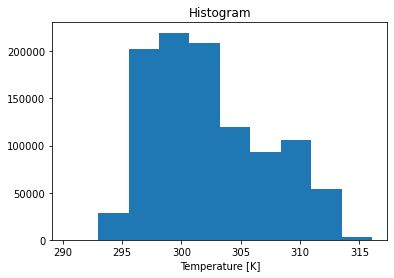

In [152]:
ds_ifs['temp'].plot()

#### Check time against station data

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


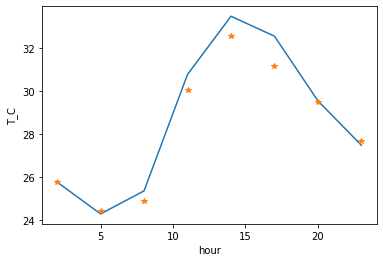

In [153]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07','2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07','2012-08'))
(_ds1['temp']-273.15).groupby(_ds1['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [154]:
varl_station_ec_earth = [
 'CCN0.20',
 'CCN1.00',
 'M_BCACS',
 'M_BCAII',
 'M_BCAIS',
 'M_BCCOS',
 'M_DUACI',
 'M_DUACS',
 'M_DUCOI',
 'M_DUCOS',
 'M_POMACS',
 'M_POMAII',
 'M_POMAIS',
 'M_POMCOS',
 'M_SO4ACS',
 'M_SO4COS',
 'M_SO4NUS',
 'M_SOAACS',
 'M_SOAAII',
 'M_SOAAIS',
 'M_SOACOS',
 'M_SOANUS',
 'M_SSACS',
 'M_SSCOS',
    'OA',
    'SOA',
 'N_ACI',
 'N_ACS',
 'N_AII',
 'N_AIS',
 'N_COI',
 'N_COS',
 'N_NUS',
 'RDRY_ACS',
 'RDRY_AIS',
 'RDRY_COS',
 'RDRY_NUS',
 'RWET_ACI',
 'RWET_ACS',
 'RWET_AII',
 'RWET_AIS',
 'RWET_COI',
 'RWET_COS',
 'RWET_NUS',
 'emiisop',
 'emiterp',
 'T',
 'DDRY_NUS',
 'DDRY_AIS',
 'DDRY_ACS',
 'DDRY_COS',
 'DWET_AII',
 'DWET_ACI',
 'DWET_COI',
 'N50',
 'N70',
 'N100',
 'N150',
 'N200',
 'N500',
 'N50-500',
 'N70-500',
 'N100-500',
 'N150-500',
 'N200-500',
 'OA',
 'POM',
 'SOA',
 'SOA2',
 'T_C',
    
]

In [155]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [156]:
ds_smll = ds_ifs[['temp']]

In [157]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud

In [158]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

N100
POM
M_POMAII
M_DUCOS
N100-500
DDRY_NUS
M_BCACS
T_C
M_SOAAII
DDRY_COS
M_DUACI
T
M_SO4ACS
M_DUACS
M_SO4COS
M_BCAIS
M_SOACOS
RDRY_ACS
DWET_AII
DWET_COI
M_SOANUS
M_POMAIS
N_NUS
N_COS
N_ACI
RDRY_AIS
RWET_AIS
N200
N50
N150
N_AIS
RDRY_COS
RWET_AII
RWET_COI
CCN1.00
emiterp
SOA2
RWET_ACI
emiisop
RDRY_NUS
SOA
M_BCCOS
N_ACS
N70
N500
N150-500
DDRY_AIS
DWET_ACI
N50-500
N200-500
CCN0.20
N_COI
RWET_COS
DDRY_ACS
M_SOAACS
M_SSACS
M_DUCOI
M_BCAII
M_SO4NUS
M_SOAAIS
N_AII
M_POMCOS
M_POMACS
OA
M_SSCOS
RWET_NUS
RWET_ACS
N70-500


#### Replace all values by station values

In [159]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

### Final adjustments


In [160]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

#### Rename variables

In [161]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [162]:
ds = dic_ds[key]

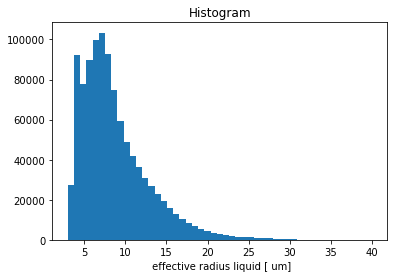

In [163]:
ds['r_eff'].plot(bins = np.linspace(3,40));

In [164]:
ds['CWP_unweigth'] = ds['tclw']

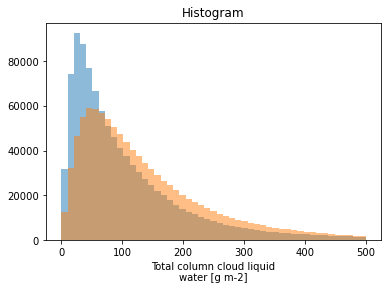

In [165]:
ds['CWP_unweigth'].plot(bins=np.linspace(0,500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0,500), alpha=.5);

#### Controle plots normalizing by cloud fraction

Text(0.5, 1.0, 'CWP divided by cloud fraction')

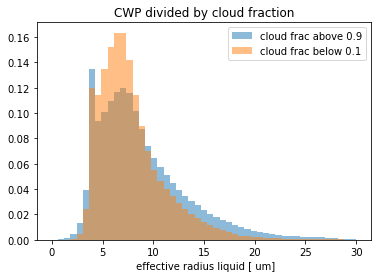

In [166]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.4).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

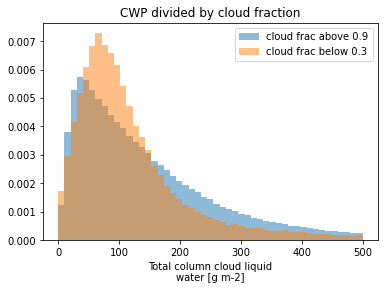

In [167]:
ds['CWP'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc']<.3).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP not divided ')

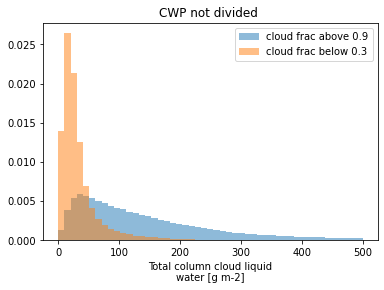

In [168]:
ds['CWP_unweigth'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc']<.3).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP not divided ')

### Final save

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv


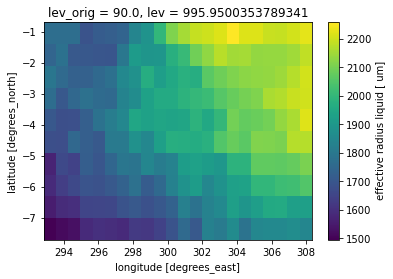

hours


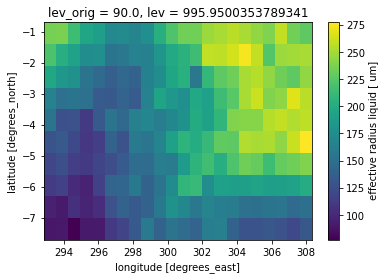

{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP!
Masking with r_eff>1!
cloud and resampled


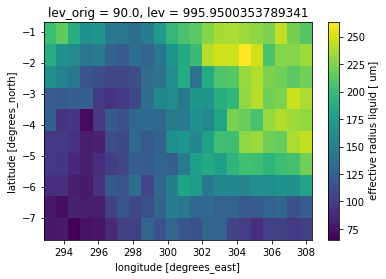

cloud_avg median


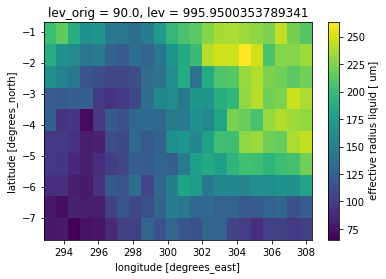

station


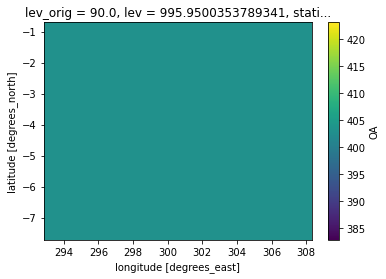

merge


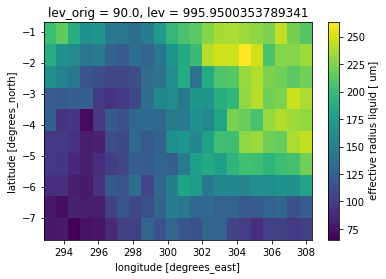

df1


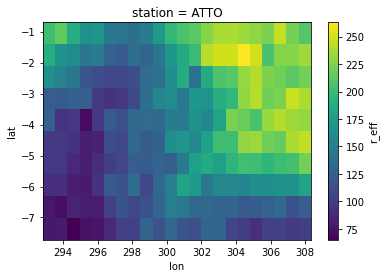

In [178]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas+'.csv')
    print(_fn_csv)
    

    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, 
                                select_hours_clouds=True, 
                                summer_months=season2month[seas],
                                mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,
                                                         min_cwp =cld_water_path_above, 
                                                         tau_bounds = tau_lims
                                                        ),
                                
                               
                               )

        df_mod = dic_df[case_name_ec_earth]
        #with ProgressBar():
        #df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

In [ ]:
dic_df.keys()

last before return


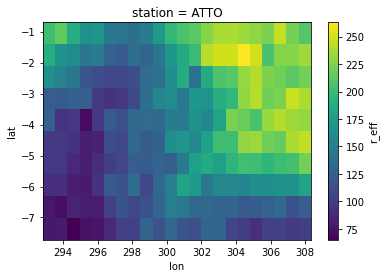

In [179]:
    df = dic_df['ECE3_output_Sara']
    print('last before return')
    #_df = df.dropna()
    _dds = df.to_xarray()
    (_dds['r_eff']
         .where(_dds['time.month'].isin([7,8]))
         .count('time').plot()
    )
    
    plt.show()

In [180]:
    df = dic_df['ECE3_output_Sara']
    print('last before return')
    #_df = df.dropna()
    _dds = df.to_xarray()
    

last before return


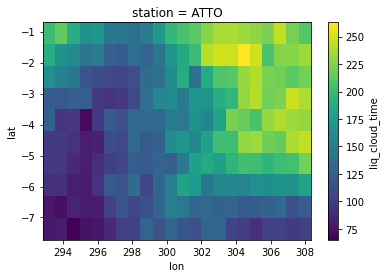

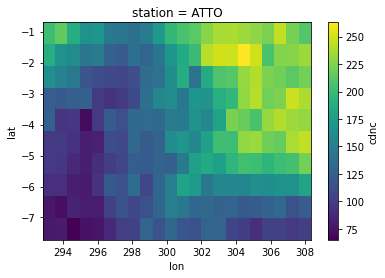

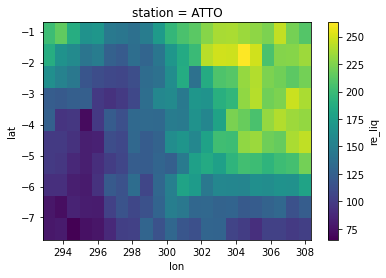

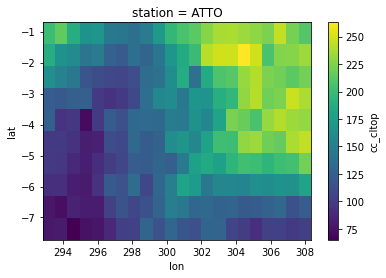

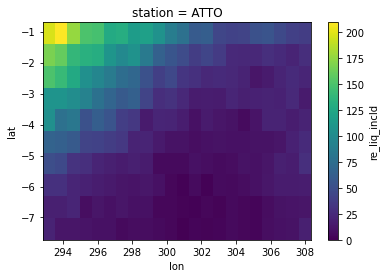

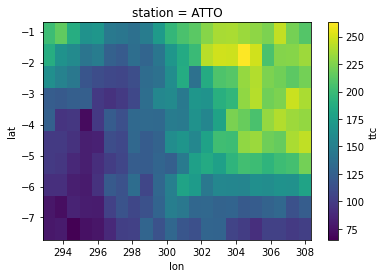

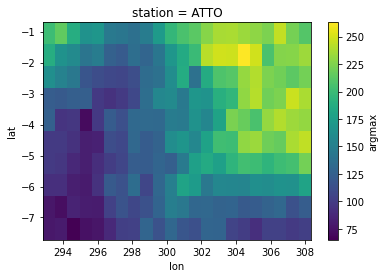

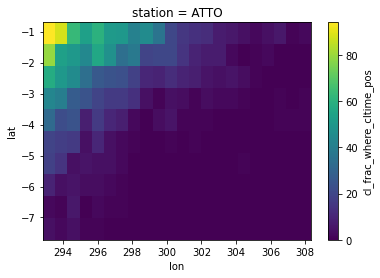

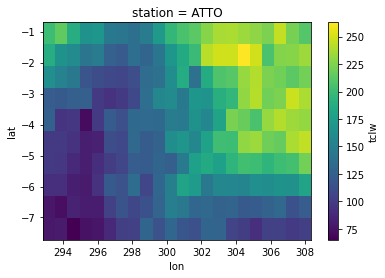

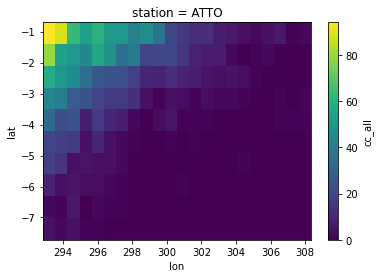

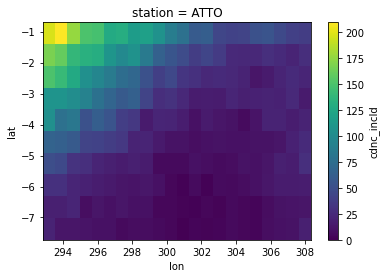

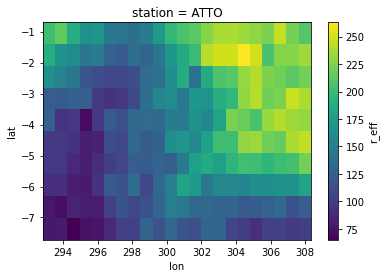

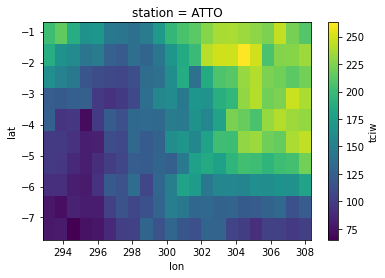

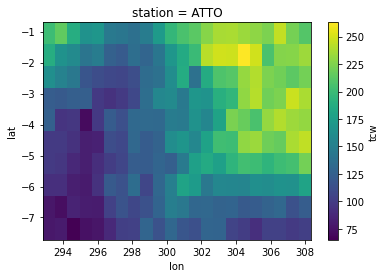

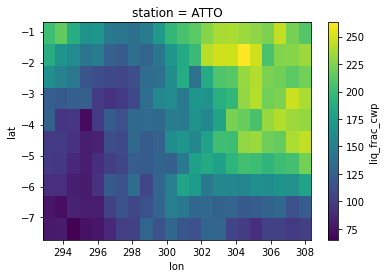

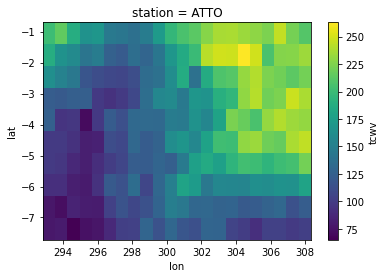

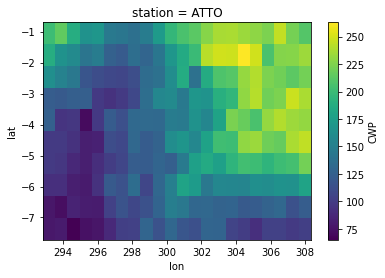

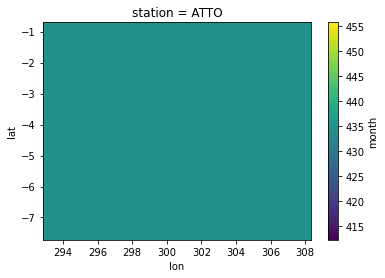

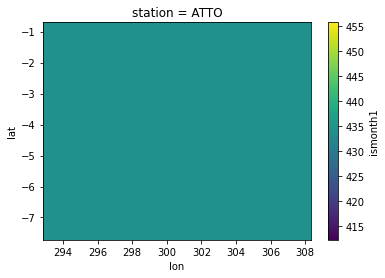

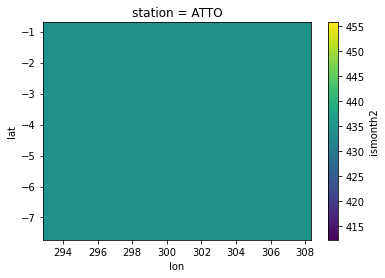

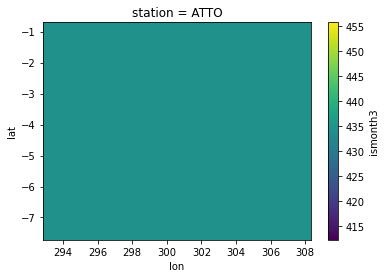

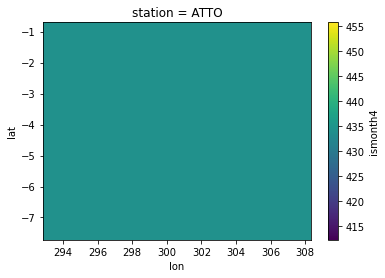

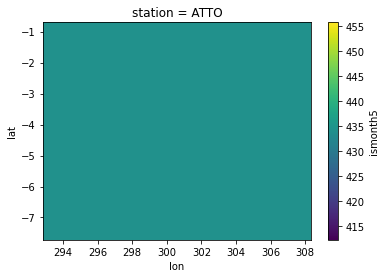

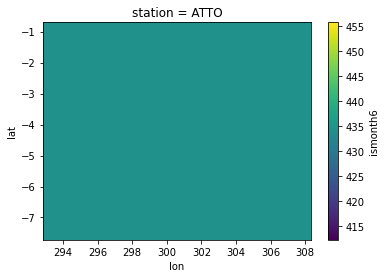

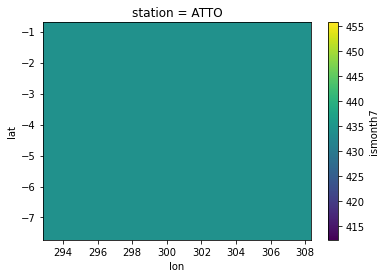

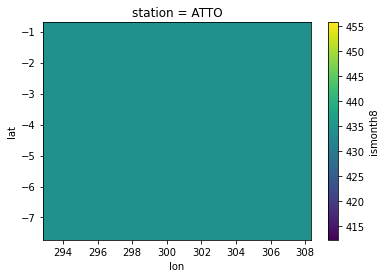

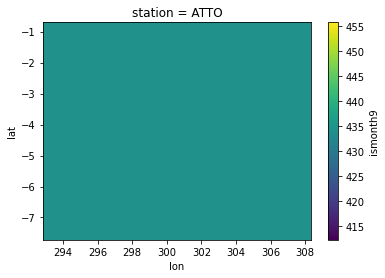

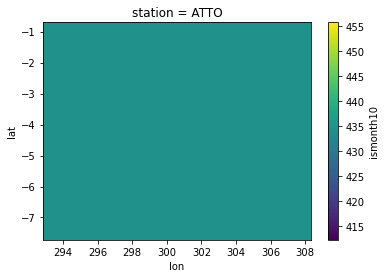

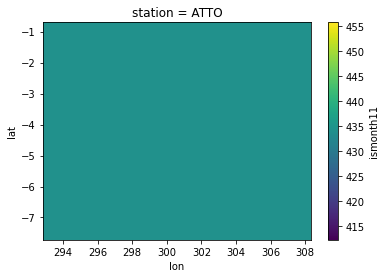

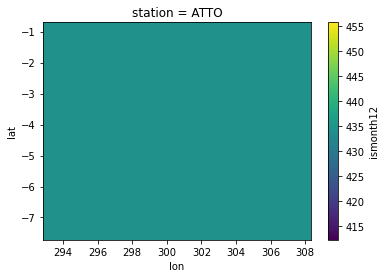

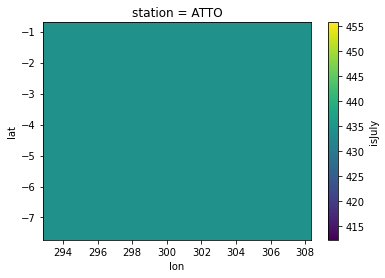

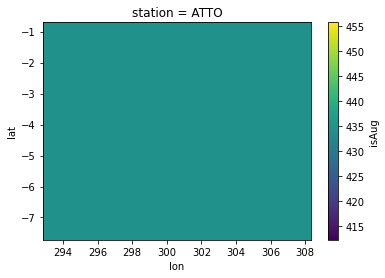

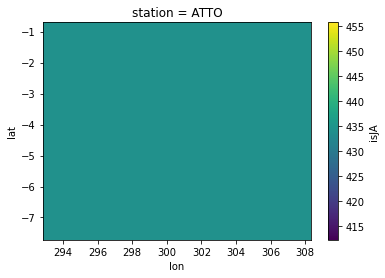

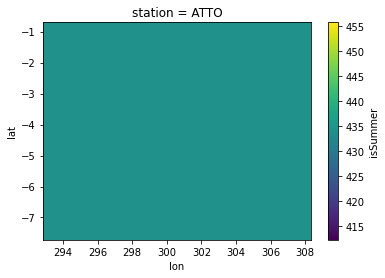

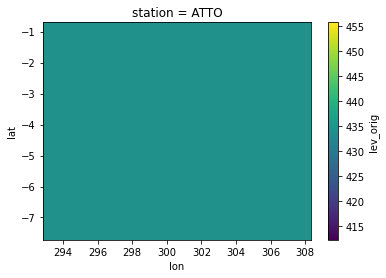

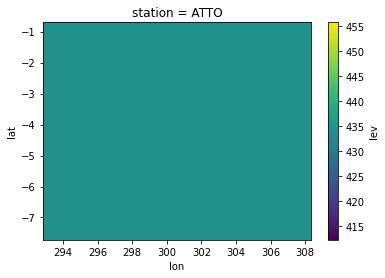

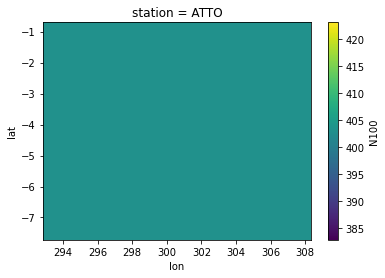

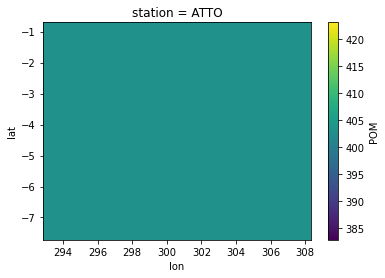

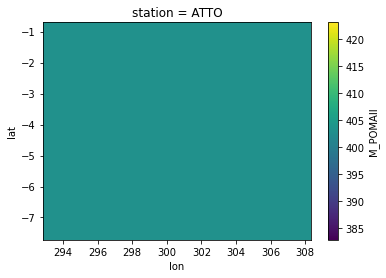

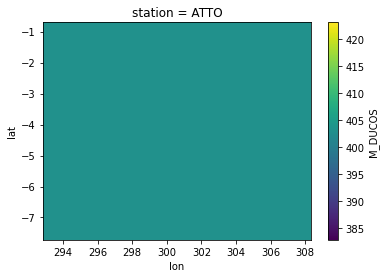

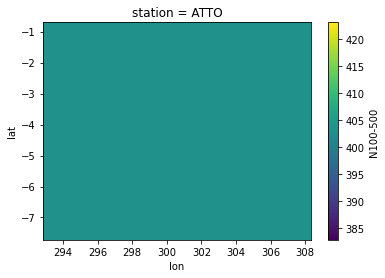

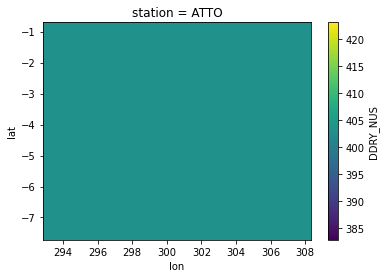

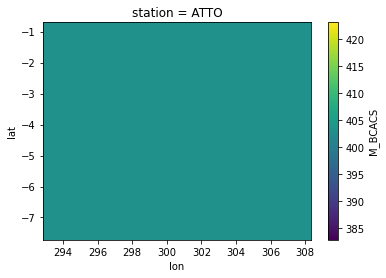

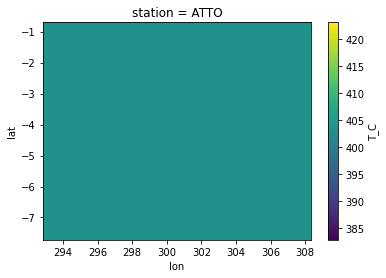

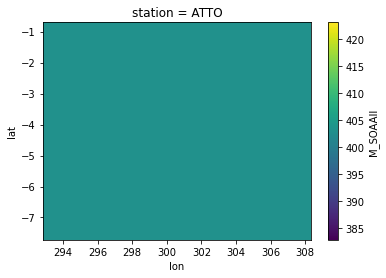

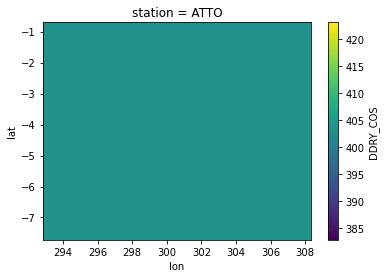

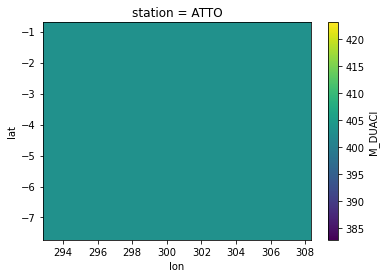

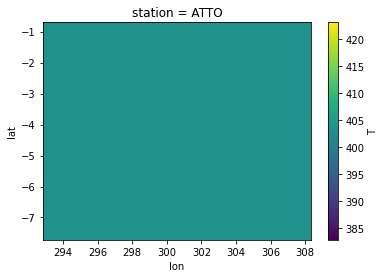

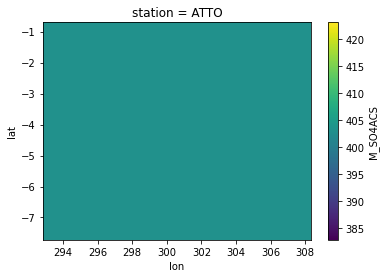

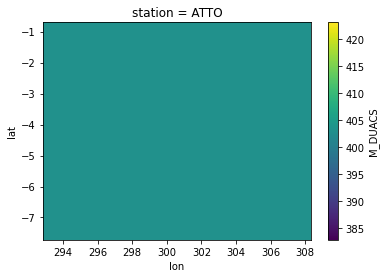

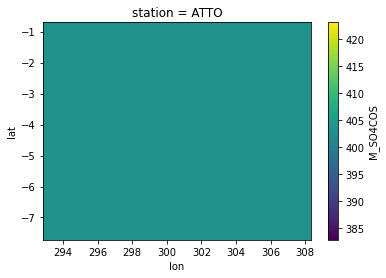

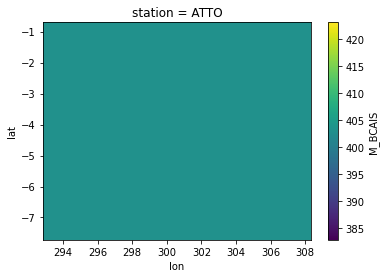

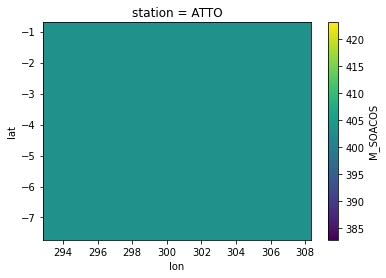

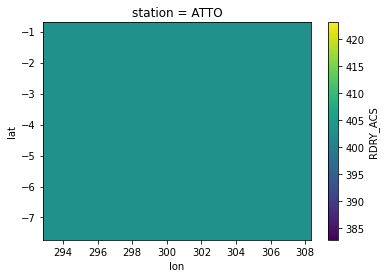

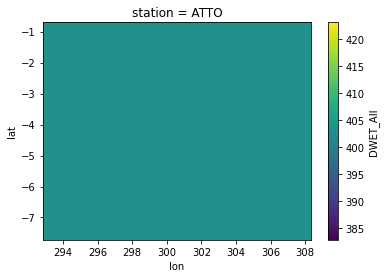

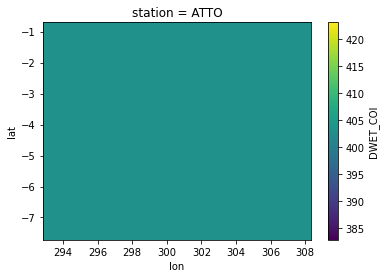

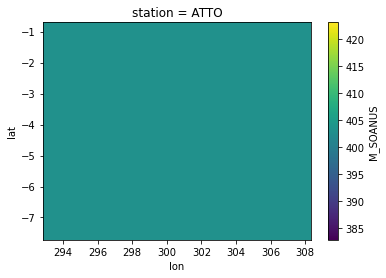

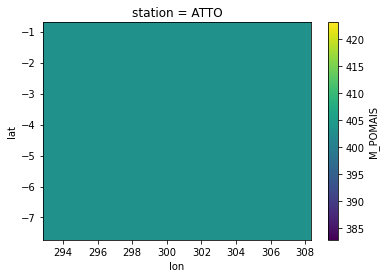

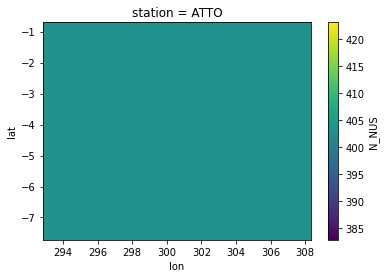

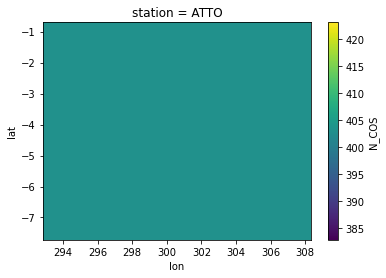

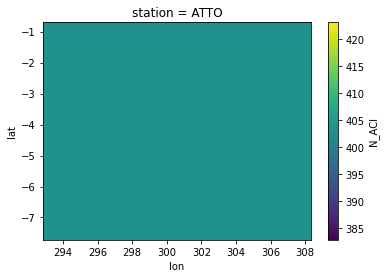

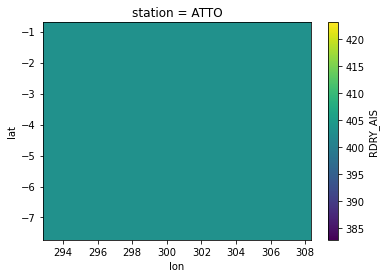

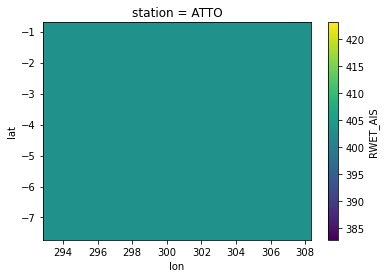

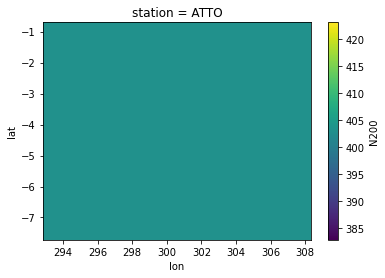

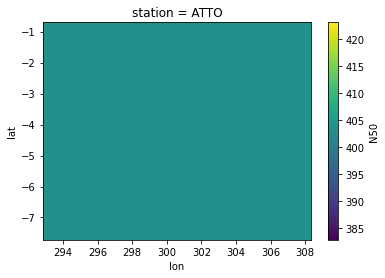

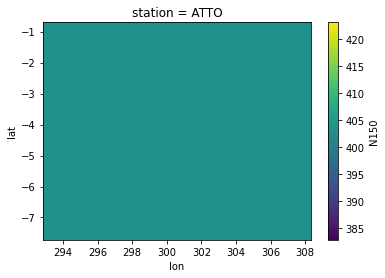

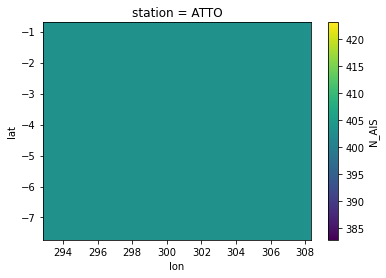

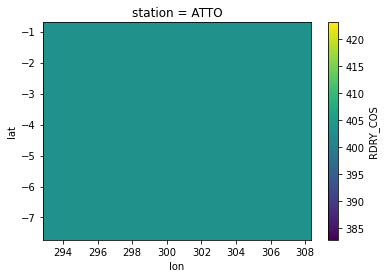

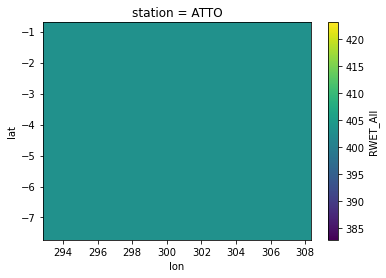

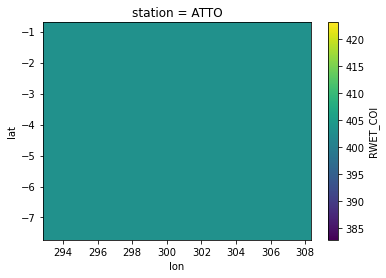

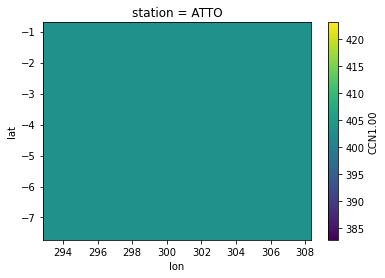

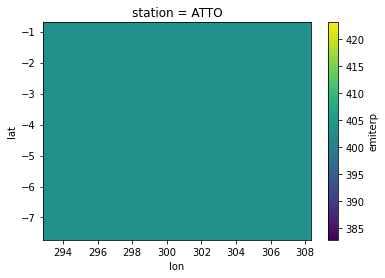

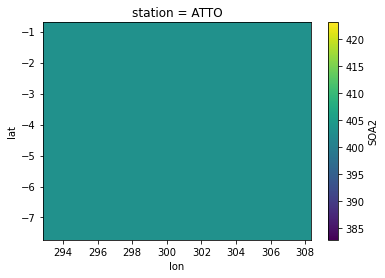

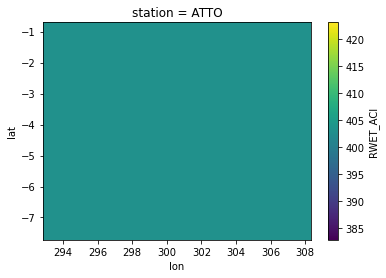

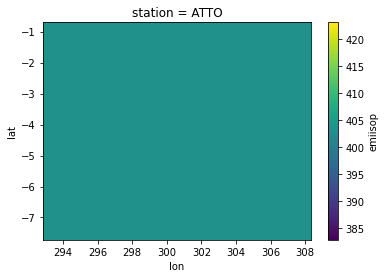

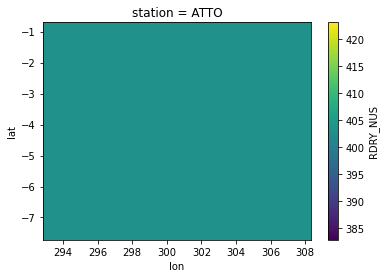

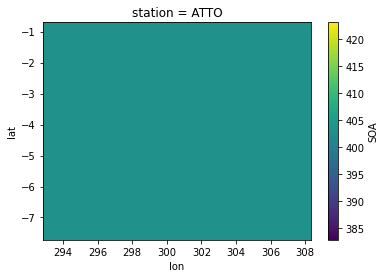

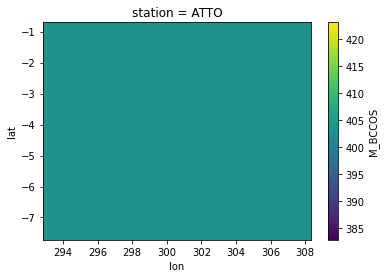

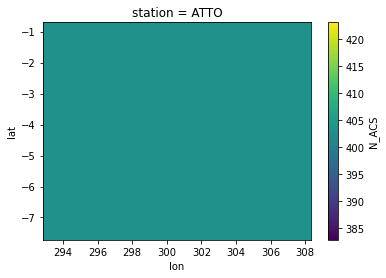

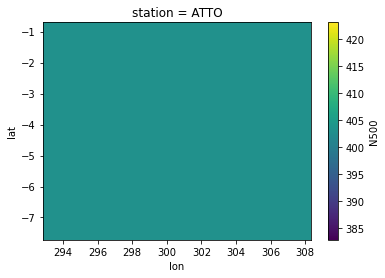

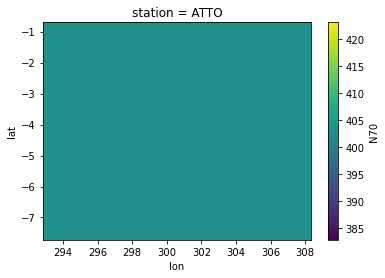

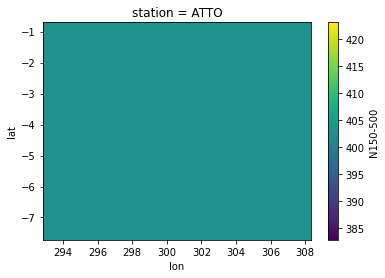

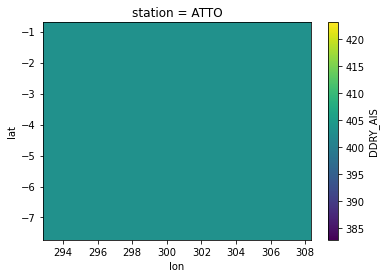

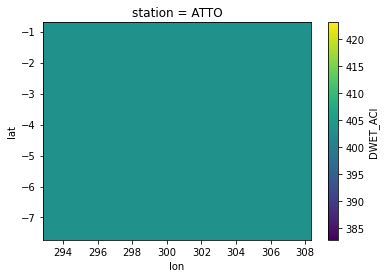

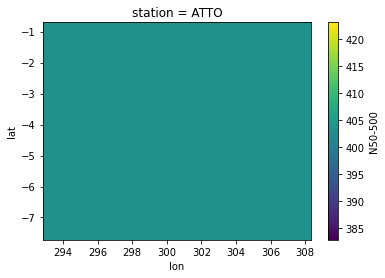

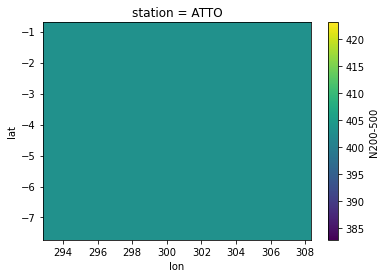

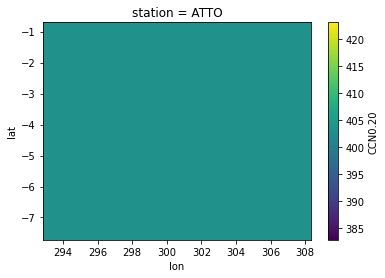

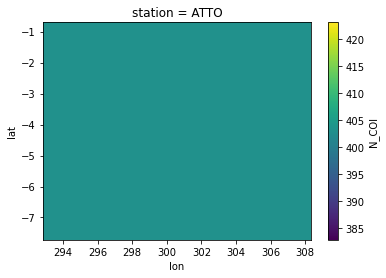

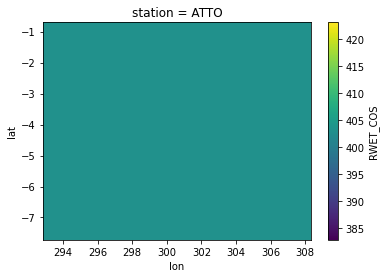

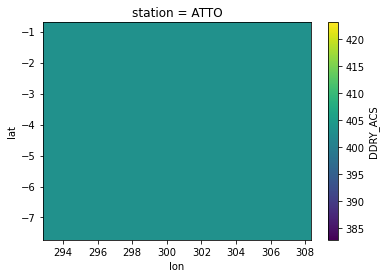

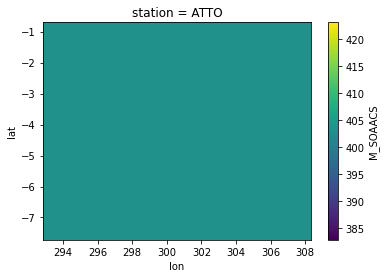

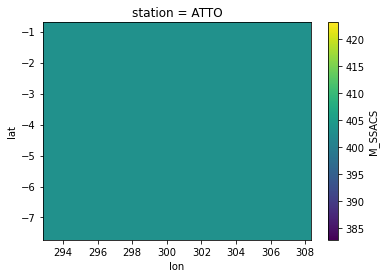

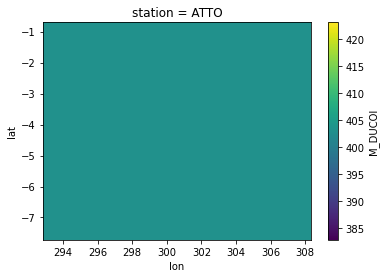

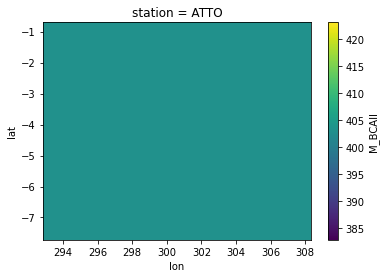

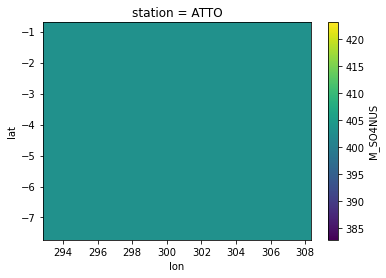

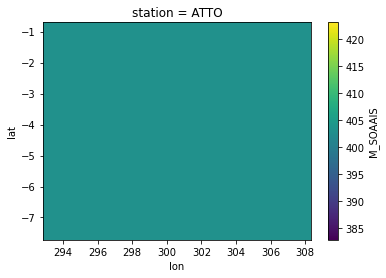

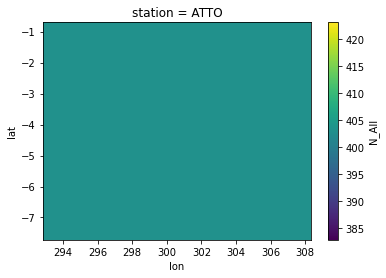

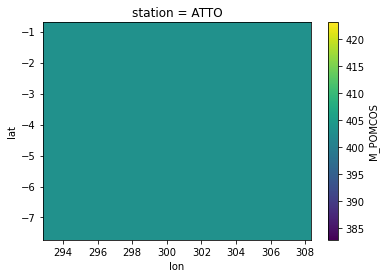

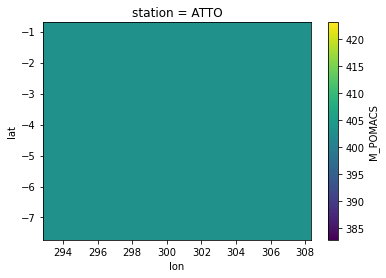

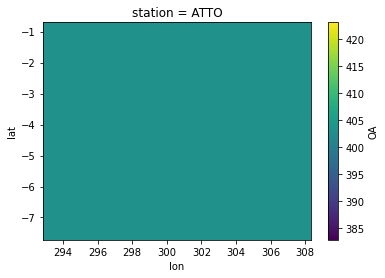

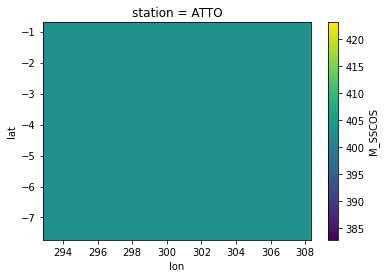

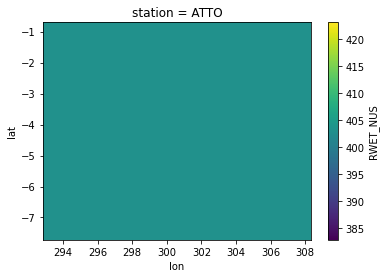

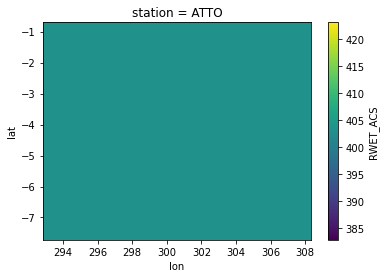

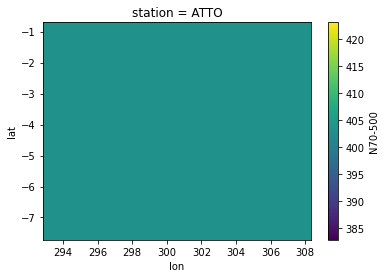

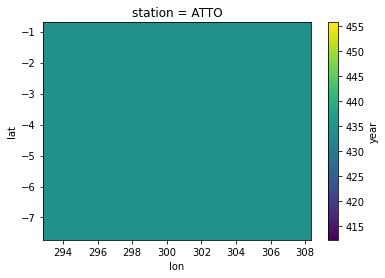

In [181]:
for v in _dds.data_vars:
    (_dds[v]
         .where(_dds['time.month'].isin([7,8]))
         .count('time').plot()
    )
    
    plt.show()

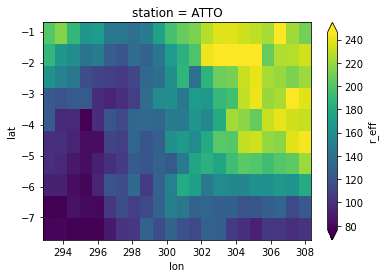

In [182]:
_dsss = df_mod.to_xarray()
(_dsss['r_eff']
 .where(_dsss['time.month'].isin([7,8]))
 .count('time').plot(robust=True)
       )

In [183]:
_fn_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [184]:
df = pd.read_csv(_fn_csv, index_col=[0,1,2])

<AxesSubplot:ylabel='Frequency'>

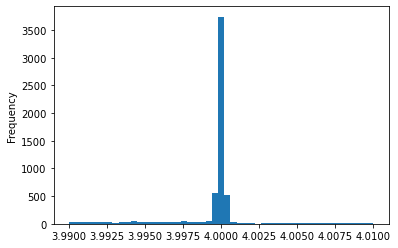

In [185]:
df['r_eff'].plot.hist(bins=np.linspace(3.99,4.01))

In [186]:
_dsf = df.to_xarray()

In [187]:
_dsf['time'] = pd.to_datetime(_dsf['time'] )

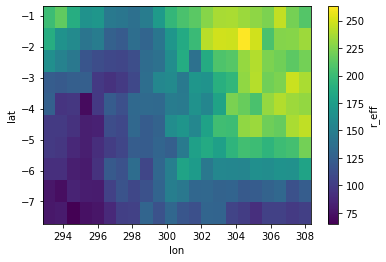

In [188]:
(_dsf
 .where(_dsf['time.month'].isin([7,8]))
 ['r_eff'].count('time')
 .plot()
)

<AxesSubplot:xlabel='time,lat,lon'>

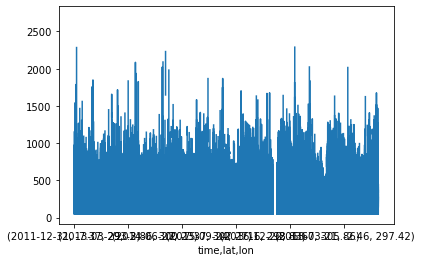

In [189]:
df['CWP'].plot()

In [190]:
df['ti_dt'] = pd.to_datetime(df.index.get_level_values(0).values)

In [191]:
df['month'] = df['ti_dt'].dt.month

<AxesSubplot:ylabel='Frequency'>

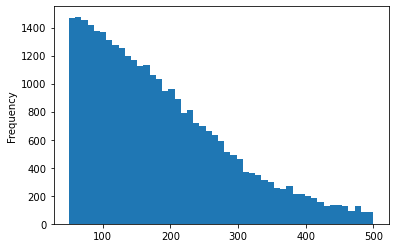

In [192]:
df[df['month'].isin([7,8])]['CWP'].plot.hist(bins = np.linspace(50,500))

<AxesSubplot:ylabel='Frequency'>

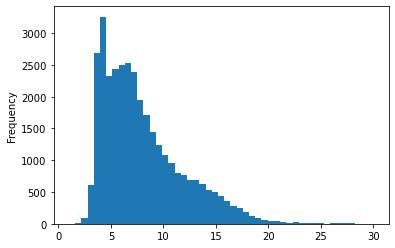

In [193]:
df[df['month'].isin([7,8])]['r_eff'].plot.hist(bins = np.linspace(1,30))

In [ ]:
from datetime import timedelta